---

## Deep Learning Coding Project 3-3: Variational Auto-Encoder

Before we start, please put your **Chinese** name and student ID in following format:

Name, 0000000000 // e.g.) 小明, 2021123123

YOUR ANSWER HERE

## Introduction

We will use Python 3, [NumPy](https://numpy.org/), and [PyTorch](https://pytorch.org/) packages for implementation. To avoid unexpected issues with PyTorch 2.0, we recommend using PyTorch version 1.x.

In this coding project, you will implement 4 generative models, i.e., energy-based model, flow-based model, variational auto-encoder, and generative adverserial network, to generate MNIST images.

**We will implement a conditional variational auto-encoder (CVAE) in this notebook.**

In some cells and files you will see code blocks that look like this:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
raise NotImplementedError()
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################
```

You should replace `raise NotImplementedError()` with your own implementation based on the context, such as:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
y = w * x + b
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

```

When completing the notebook, please adhere to the following rules:

+ Unless otherwise stated, do not write or modify any code outside of code blocks
+ Do not add or delete any cells from the notebook.
+ Run all cells before submission. We will not re-run the entire codebook during grading.

**Finally, avoid plagiarism! Any student who violates academic integrity will be seriously dealt with and receive an F for the course.**

### Task

In this problem, you need to implement a class conditioned variational autoencoder to generate MNIST images. We suppose the prior $p(z)$ is a
standard Gaussian distribution $\mathcal{N} (0, I)$. Also, we assume $q(z|x, y)$ and $p(x|z, y)$
are Gaussian distributions.

1. **You need to complete the encoder $q(z|x, y; \phi)$ and the decoder $p(x|z, y; \theta)$, which are both MLPs**.

2. **Implement the VAE loss function.**

An example of generated images using CVAE is shown below.

If you use Colab in this coding project, please uncomment the cell below, change the `GOOGLE_DRIVE_PATH` to your project folder and run the following cell to mount your Google drive. Then, the notebook can find the required files (i.e., utils.py). If you run the notebook locally, you can skip this cell.

In [25]:
# ### uncomment this cell if you're using Google colab
# from google.colab import drive
# drive.mount('/content/drive')

# ### change GOOGLE_DRIVE_PATH to the path of your CP3 folder
# GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/DL23SP/CP3'
# %cd $GOOGLE_DRIVE_PATH

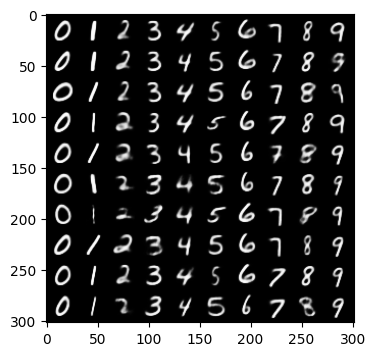

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 6, 4
plt.imshow(mpimg.imread('./vae/sample.png'))

### Submission

You need to submit your code (this notebook), your trained VAE model (named `./vae/vae_best.pth`), your generated images, and your report:

+ **Code**

Remember to run all the cells before submission. Remain your tuned hyperparameters unchanged.

+ **Generator**

In this notebook, we select the best model based on validation loss. You can also manually select the best one, and save it as `./vae/vae_best.pth`. **Please do not submit any other checkpoints except for `./vae/vae_best.pth`!**

+ **Generated Images**

Please generate 100 images for each class (1000 in total), save it in `./vae/generated/`, and organize them as the following structure:

```
CodingProject3
├── ...
├── vae
│   ├── vae_best.pth
│   ├── generated
│       └── 0
│           ├── 0_00.png
│           ├── ...
│           ├── 0_99.png
│       └── 1
│           ├── 1_00.png
│           ├── ...
│           ├── 1_99.png
│       └── ...
│       └── 9
│           ├── 9_00.png
│           ├── ...
│           ├── 9_99.png
```

Specifially, you should name the $j$-th generated image of class $i$ as `{i}_{j}.png`, and save it into folder `./vae/generated/{i}/`. Check the `make_dataset` method of VAE model for details.

+ **Report**

Please include the conditioned generation results (i.e., generated images in a $10\times 10$ array as above), the FID score, the standard deviation for each class, and other relevant statistics in your
report. Note that you only need to write a single report for this coding project.

### Grading

We will evaluate your model by **computing the [FID score](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance)**. We have provided a fine-tuned Inception-V3 model, which will be used by our evaluation script to compute FID score.

## Set Up Code

If you use Colab in this coding project, please make sure to mount your drive before running the cells below.

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from utils import hello
hello()

Good luck!


Please run the following cell to import some base classes for implementation (no matter whether you use colab).

In [29]:
from collections import deque
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm

import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from utils import save_model, load_model, train_set, val_set

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

## VAE Model

Complete the conditional VAE model with structure shown in doc strings.

**Hint**: we usually output logarithm standard deviation.

In [30]:
class CVAE(nn.Module):
    def __init__(self, img_size, label_size, latent_size, hidden_size):
        super(CVAE, self).__init__()
        self.img_size = img_size  # (C, H, W)
        self.label_size = label_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        
        # Encoder.
        self.en_img = nn.Sequential(
            nn.Linear(np.prod(img_size), hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(hidden_size)
        )
        self.en_label = nn.Linear(label_size, hidden_size)
        
        self.conbine = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(hidden_size)
        )

        self.fc_mu = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, int(hidden_size/2)),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(int(hidden_size/2)),
            nn.Linear(int(hidden_size/2), latent_size)
        )
        self.fc_logstd = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, int(hidden_size/2)),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(int(hidden_size/2)),
            nn.Linear(int(hidden_size/2), latent_size)
        )
        
        # Decoder.
        self.de_z = nn.Sequential(
            nn.Linear(latent_size, int(hidden_size/2)),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(int(hidden_size/2)),
            nn.Linear(int(hidden_size/2), hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(hidden_size)
        )
        self.de_label = nn.Sequential(
            nn.Linear(label_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(hidden_size, hidden_size)
        )
        self.fc_out = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, np.prod(img_size)),
            nn.Sigmoid()
        )
        
    def encode_param(self, x, y):
        # compute mu and logstd of p(z|x, y)
        h_img = self.en_img(x.view(x.size(0), -1))
        
        h_label = self.en_label(y)
        
        h = self.conbine(torch.cat([h_img, h_label], dim=1))
        
        mu = self.fc_mu(h)
        logstd = self.fc_logstd(h)
        
        return mu, logstd

    def reparamaterize(self, mu: torch.Tensor, logstd: torch.Tensor):
        # compute latent z with reparameterization trick
        std = torch.exp(0.5 * logstd)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def encode(self, x, y):
        # sample latent z from p(z|x, y)
        mu, logstd = self.encode_param(x, y)
        z = self.reparamaterize(mu, logstd)
        return z

    def decode(self, z, y):
        h_z = self.de_z(z)
        h_label = self.de_label(y)
        
        h = torch.cat([h_z, h_label], dim=1)
        
        out = self.fc_out(h)
        return out.view(-1, *self.img_size)

    @torch.no_grad()
    def sample_images(self, label, save=True, save_dir='./vae'):
        self.eval()
        n_samples = label.shape[0]
        samples  = self.decode(torch.randn(n_samples, self.latent_size).to(label.device), label)
        imgs = samples.view(n_samples, 1, 28, 28).clamp(0., 1.)
        if save:
            os.makedirs(save_dir, exist_ok=True)
            torchvision.utils.save_image(imgs, os.path.join(save_dir, 'sample.png'), nrow=int(np.sqrt(n_samples)))
        return imgs
    
    @torch.no_grad()
    def make_dataset(self, n_samples_per_class=10, save=True, save_dir='./vae/generated/'):
        self.eval()
        device = next(self.parameters()).device
        for i in range(self.label_size):
            label = torch.zeros(n_samples_per_class, self.label_size, device=device)
            label[:, i] = 1
            samples = self.decode(torch.randn(
                n_samples_per_class, self.latent_size).to(device), label)
            imgs = samples.view(n_samples_per_class, 1, 28, 28).clamp(0., 1.)
            if save:
                os.makedirs(os.path.join(save_dir, str(i)), exist_ok=True)
                for j in range(n_samples_per_class):
                    torchvision.utils.save_image(imgs[j], os.path.join(save_dir, str(i), "{}_{:>03d}.png".format(i, j)))


## VAE Loss

Given image $x$ and corresponding label $y$, compute the VAE loss in the following function.

**Hint**: $p(x|z, y)$ is a real-valued Gaussian distribution, while images are in range $[0, 1]$. Therefore, you may want to transform $x$ when computing $p(x|z, y)$.

In [31]:
def compute_vae_loss(vae_model, x, y, beta=1):
    # compute vae loss for input x and label y
    # Encode input x and label y to get latent z
    vae_model.eval()
    z = vae_model.encode(x, y)
    
    # Decode z to reconstruct the image
    x_reconstructed = vae_model.decode(z, y)
    
    # Compute reconstruction loss (Binary Cross-Entropy)
    reconstruction_loss = F.binary_cross_entropy(x_reconstructed.view(-1, vae_model.img_size[0] * vae_model.img_size[1] * vae_model.img_size[2]), 
                                                 x.view(-1, vae_model.img_size[0] * vae_model.img_size[1] * vae_model.img_size[2]), 
                                                 reduction='sum')
    
    # Compute the KL divergence
    mu, logstd = vae_model.encode_param(x, y)
    kl_divergence = -0.5 * torch.sum(1 + logstd - mu.pow(2) - logstd.exp())
    
    # Compute VAE loss
    vae_loss = reconstruction_loss + beta * kl_divergence
    
    return vae_loss


## Training & Evaluation

We have implemented the training and evaluation functions. Feel free to modify `train` if you want to monitoring more information. Make sure your best model is stored in `'./vae/vae_best.pth'`.

In [32]:
@torch.no_grad()
def evaluate(vae_model, loader, device, beta):
    vae_model.eval()
    val_loss = 0
    n_batches = 0

    pbar = tqdm(total=len(loader.dataset))
    pbar.set_description('Eval')
    for batch_idx, (x, y) in enumerate(loader):
        n_batches += x.shape[0]
        x = x.view(x.shape[0], -1).to(device)
        y = F.one_hot(y, num_classes=vae_model.label_size).to(device).float()

        val_loss += compute_vae_loss(vae_model, x, y, beta).sum().item()
        pbar.update(x.size(0))
        pbar.set_description('Val Loss: {:.6f}'.format(val_loss / n_batches))

    pbar.close()
    return val_loss / n_batches

In [33]:
def train(n_epochs, vae_model, train_loader, val_loader, optimizer, beta=1, device=torch.device('cuda'), save_interval=10):
    vae_model.to(device)
    best_val_loss = np.inf

    for epoch in range(n_epochs):
        train_loss = 0
        n_batches = 0
        pbar = tqdm(total=len(train_loader.dataset))
        for i, (x, y) in enumerate(train_loader):
            # compute loss
            vae_model.train()
            n_batches += x.shape[0]
            x = x.view(x.shape[0], -1).to(device)
            y = F.one_hot(y, num_classes=vae_model.label_size).to(device).float()
            loss = compute_vae_loss(vae_model, x, y, beta)

            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

            train_loss += loss.sum().item()

            pbar.update(x.size(0))
            pbar.set_description('Train Epoch {}, Train Loss: {:.6f}'.format(epoch + 1, train_loss / n_batches))
        pbar.close()

        if (epoch + 1) % save_interval == 0:
            os.makedirs(f'./vae/{epoch + 1}', exist_ok=True)
            vae_model.eval()
            save_model(f'./vae/{epoch + 1}/vae.pth', vae_model, optimizer)

            val_loss = evaluate(vae_model, val_loader, device, beta=beta)

            # sample and save images
            label = torch.eye(10).repeat(10, 1).to(device)
            vae_model.sample_images(
                label, save=True, save_dir=f"./vae/{epoch + 1}/")
            
            if val_loss < best_val_loss:
                print(
                    f'Current validation loss: {best_val_loss} -> {val_loss}')
                best_val_loss = val_loss
                save_model('./vae/vae_best.pth', vae_model)

## Enjoy

Tune your hyperparameters and make your conditional VAE work. Good luck!

In [34]:
label_dim = 10
img_dim = (1, 28, 28)
latent_dim = 128
cvae = CVAE(img_dim, 10, 128, 512)

train_loader = DataLoader(train_set, batch_size=256, pin_memory=True,
                          drop_last=False, shuffle=True, num_workers=8, persistent_workers=True)
val_loader = DataLoader(val_set, batch_size=512, pin_memory=True,
                        drop_last=True, shuffle=True, num_workers=8, persistent_workers=True)
optimizer = torch.optim.Adam(cvae.parameters(), lr=2e-4, weight_decay=1e-5)

Let's start training! Please keep in mind that this cell may **NOT** be run when we evaluate your assignment!

In [35]:
# feel free to change training hyper-parameters!
train(100, cvae, train_loader, val_loader, optimizer, device=device, save_interval=10)

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: inf -> 140.50402510793586


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 140.50402510793586 -> 137.90046852513365


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 137.90046852513365 -> 137.5363600881476


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 137.5363600881476 -> 129.7450240285773


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 129.7450240285773 -> 126.56781688489411


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 126.56781688489411 -> 124.74285808362458


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 124.74285808362458 -> 121.9078553852282


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 121.9078553852282 -> 120.19936330694901


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 120.19936330694901 -> 119.96928726999383


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 119.96928726999383 -> 118.84398691277755


## Evaluation

Make sure your code runs fine with the following cells!

In [36]:
# collect model-generated samples
cvae.load_state_dict(load_model('./vae/vae_best.pth')[0])
cvae.make_dataset(n_samples_per_class=100)

d:\课程\大二下\深度学习\CodingProject3\utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)


In [37]:
# run evaluation
!python evaluate_cgen.py --vae

FID score for 10 classes: [ 9.729778   4.3459783 19.134884  14.227808   8.395357  10.0353
  6.454054  10.010896  17.087881   8.698973 ]


c:\Users\Tommy\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tommy\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\课程\大二下\深度学习\CodingProject3\evaluate_cgen.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (Se